# Image Classification Using CNN in PyTorch

1️⃣ Introduction

This project implements an image classification model using a Convolutional Neural Network (CNN) in PyTorch. The model classifies images into three categories: Benign, Malignant, and Normal.

2️⃣ Importing Required Libraries

We begin by importing the necessary libraries.

Library Explanations

NumPy (numpy): Used for numerical computations and handling image data in array format.

Matplotlib (matplotlib.pyplot): Helps in visualizing images and performance metrics.

OpenCV (cv2): Used for image processing, reading, and resizing images.

PyTorch (torch): Core deep learning library.

Torch.nn (torch.nn): Provides neural network layers and functions.

Torch.optim (torch.optim): Provides optimization algorithms (SGD, Adam, etc.).

Torchvision (torchvision): Contains datasets, transforms, and pretrained models.

Dataloader (torch.utils.data.DataLoader): Helps load datasets efficiently in batches.

OS (os): For handling file paths and directories.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os

3️⃣ Loading and Transforming the Dataset

We will load the dataset and apply transformations like resizing, normalization, and converting images into tensors.

512


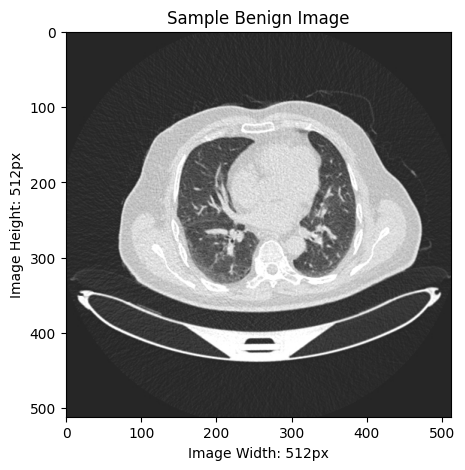

In [4]:
# creating paths for the urls
train_dir = "../datasets/LungCancer_CT_Dataset/TestDataset/"
test_dir = "../datasets/LungCancer_CT_Dataset/TestDataset/"
sample_image = cv2.imread(os.path.join(train_dir, "Benign/Bengin case (1).jpg"))

# getting the sample image info
image_size = sample_image.shape
print(image_size[0])

plt.figure(figsize=(8,5))
plt.title("Sample Benign Image")
plt.imshow(sample_image)

plt.xlabel("Image Width: {0}px".format(image_size[0]))
plt.ylabel("Image Height: {0}px".format(image_size[1]))

plt.show()

In [6]:
class PrepareData:
    def __init__(self, directory_path : str, image_size : tuple, batch_size : int) -> DataLoader:
        self.directory_path = directory_path
        self.image_size = image_size
        self.batch_size = batch_size

    def prepare_dataset(self):
        transform = transforms.Compose([
                transforms.Resize((image_size[0], image_size[1])),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
            ])
        
        dataset = datasets.ImageFolder(
            root=self.directory_path,
            transform=transform
        )

        loaded_data = DataLoader(
                dataset,
                batch_size=self.batch_size,
                shuffle=True,
                num_workers=4
            )
        
        return loaded_data

In [7]:
image_size = (64, 64, 3)

test_dataset = PrepareData(directory_path=test_dir, batch_size=8, image_size=image_size).prepare_dataset()
train_dataset = PrepareData(directory_path=train_dir, batch_size=8, image_size=image_size).prepare_dataset()

4️⃣ Building the CNN Model

Now, we define the CNN architecture for image classification.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (32, 32, 32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (16, 16, 64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (8, 8, 128)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (4, 4, 256)

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)  # Changed from 256*11*11 to 256*4*4
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))
        
        x = x.view(x.size(0), -1)  # Flatten
        
        x = self.dropout(self.relu_fc1(self.fc1(x)))
        x = self.fc2(x)  # Output logits
        
        return x

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ",device)

model = CNN(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Device:  cpu


5️⃣ Training the Model

We define the loss function and optimizer, then train the CNN.

In [10]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_dataset:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataset):.4f}")


Epoch [1/10], Loss: 3.2111
Epoch [2/10], Loss: 1.4676
Epoch [3/10], Loss: 1.2097
Epoch [4/10], Loss: 0.6481
Epoch [5/10], Loss: 0.6189
Epoch [6/10], Loss: 0.4743
Epoch [7/10], Loss: 0.2417
Epoch [8/10], Loss: 0.1116
Epoch [9/10], Loss: 0.0392
Epoch [10/10], Loss: 0.0532


6️⃣ Evaluating the Model

After training, we evaluate the model's performance on test data.

In [11]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataset:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

Accuracy on test set: 100.00%


In [12]:
# checking the model's loading and evaluation
output_dir = "../models/lung_cancer_detector.pth"
torch.save(model.state_dict(), output_dir)

In [13]:
cancer_detector_model = model.load_state_dict(torch.load(output_dir))
print(model.eval())
print("model is packaged and loaded perfectly...")

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU

7️⃣ Making Predictions on New Images

We use the trained model to classify new images.

In [14]:
from PIL import Image
from torchvision import transforms


transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

# Load and transform the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Ensure RGB format
    image = transform(image)  # Apply transformations
    image = image.unsqueeze(0)  # Add batch dimension
    return image

In [15]:
print(train_dataset.batch_size)

8


In [16]:
# Define class labels
import torch

class_labels = ["Benign", "Malignant", "Normal"]

def predict_image(image_path):
    image = preprocess_image(image_path)

    # Forward pass through the model
    with torch.no_grad():
        output = model(image)
        predicted_class = torch.argmax(output, dim=1).item()

    return class_labels[predicted_class]

# Example usage
image_path = "../datasets/LungCancer_CT_Dataset/TestDataset/Malignant/Malignant case (10).jpg"  # Replace with your image file
prediction = predict_image(image_path)
print(f"Prediction: {prediction}")

Prediction: Malignant


In [17]:
import torch

torch.save(model.state_dict(), "lung_cancer_detector.pth")
print("Model weights saved!")


Model weights saved!
